In [349]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
from torch.utils.data import random_split
from torch import nn
import warnings

import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore', category=FutureWarning)

Matplotlib is building the font cache; this may take a moment.


### Set random seed

In [308]:
torch.manual_seed(0)

# Creating a Custom Dataset 

In [309]:
## Define a class for the dataset

class MoleculeDataset(Dataset):
    def __init__(self, dataframe, features, target):
        self.dataframe = dataframe
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        features = torch.tensor(row[self.features].values, dtype=torch.float32)
        target = torch.tensor(row[self.target], dtype=torch.float32)
        return features, target


In [310]:
## Create a dataset
df = pd.read_csv('./set1.csv')
features = ['HDonors_norm', 'HAcceptors_norm', 'MolWt_norm', 'LogP_norm']
target = ['Active']
dataset = MoleculeDataset(df, features, target)

In [311]:
# Split into testing and training sets
generator1 = torch.Generator().manual_seed(42)
# generator1 = torch.Generator().manual_seed(1)
test_data, training_data = random_split(dataset, [.2, .8], generator=generator1)

In [312]:
batch_size=64
# Create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

counter=0
for X, y in train_dataloader:
    # print("X, Features:", X)
    # print("y, Target:", y)
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    counter+=1
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

counter

Shape of X [N, C, H, W]: torch.Size([64, 4])
Shape of y: torch.Size([64, 1]) torch.float32


1

# Create a model

# Single layer neural network - perceptron

In [313]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [314]:
class Perceptron(nn.Module):
    
    def __init__(self, input_size):
        super().__init__()
        # Define the hidden layer with input_size input features and hidden_neurons neurons
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [315]:
model = Perceptron(4).to(device)
print(model)

Perceptron(
  (linear): Linear(in_features=4, out_features=1, bias=True)
)


# Optimizing model parameters

In [316]:
# Binary cross entropy loss function
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [346]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    # losses = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 20 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    # losses += [loss]
    # return losses
    

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    print("N_batches in the test set", num_batches)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.flatten()).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss

# Train the model

In [ ]:
epochs = 100

ep_n = []
loss_n = []

# weights_n = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    loss = test(test_dataloader, model, loss_fn)
    loss_n += [loss]
    ep_n += [t]
print("Done!")


Epoch 1
-------------------------------
loss: 0.466521  [   64/ 3601]
loss: 0.324926  [ 1344/ 3601]
loss: 0.359932  [ 2624/ 3601]
N_batches in the test set 15
Test Error: 
 Accuracy: 88.3%, Avg loss: 0.356541 

Epoch 2
-------------------------------
loss: 0.466427  [   64/ 3601]
loss: 0.320546  [ 1344/ 3601]
loss: 0.357322  [ 2624/ 3601]
N_batches in the test set 15
Test Error: 
 Accuracy: 88.3%, Avg loss: 0.353708 

Epoch 3
-------------------------------
loss: 0.466468  [   64/ 3601]
loss: 0.316719  [ 1344/ 3601]
loss: 0.355075  [ 2624/ 3601]
N_batches in the test set 15
Test Error: 
 Accuracy: 88.3%, Avg loss: 0.351239 

Epoch 4
-------------------------------
loss: 0.466608  [   64/ 3601]
loss: 0.313356  [ 1344/ 3601]
loss: 0.353134  [ 2624/ 3601]
N_batches in the test set 15
Test Error: 
 Accuracy: 88.3%, Avg loss: 0.349075 

Epoch 5
-------------------------------
loss: 0.466821  [   64/ 3601]
loss: 0.310389  [ 1344/ 3601]
loss: 0.351449  [ 2624/ 3601]
N_batches in the test set 

Text(0.5, 0, 'Epoch')

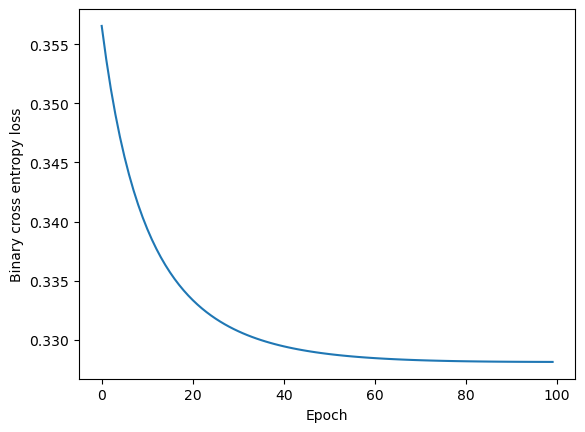

In [376]:
## Loss reduction during training
plt.plot(ep_n, loss_n)
plt.ylabel("Binary cross entropy loss")
plt.xlabel("Epoch")

In [386]:
## Save model parameters
torch.save(model.state_dict(), 'h1_lipinski_model.pth')

In [387]:
model.state_dict()['linear.weight'][0].cpu().numpy()

array([ 0.03887186, -0.24006966,  0.48728463,  0.5072787 ], dtype=float32)

Accuracy: 88.3%,
Average loss: 0.351

# 10-Fold Cross-Validation

In [ ]:
### ....